In [2]:
import ipyparallel as parallel
client = parallel.Client(profile='default')
view = client.load_balanced_view()
len(client.ids)

10

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# %%px --local
from ase.io import read
import numpy as np
from ase.units import fs, Ang

In [5]:
def get_t_corr(dt, path, lim):
    
    from ase.io import read
    import numpy as np
    from ase.units import fs, Ang
    
    def water_cm(x):
        x = x.reshape(-1,3,3)
        return ((16*x[:,0] + x[:,1] + x[:,2])/18)


    trajectories = read(path, lim)
    v = []
    all_v = []
    for i, traj in enumerate(trajectories[int(dt):]):
        v1 = traj.get_velocities()[0::3]
        all_v.append(np.mean(np.einsum('ij,ij -> i' , v1, v1)))
        v2 = trajectories[i].get_velocities()[0::3]
        v.append(np.mean(np.einsum('ij,ij -> i' , v1, v2)))
    return np.mean(v)/np.mean(all_v)


def get_t_corr_cm(dt, path, lim):
    from ase.io import read
    import numpy as np
    from ase.units import fs, Ang

    def water_cm(x):
        x = x.reshape(-1,3,3)
        return ((16*x[:,0] + x[:,1] + x[:,2])/18)
    
    trajectories = read(path, lim)
    v = []
    all_v = []
    for i, traj in enumerate(trajectories):
        trajectories[i].set_momenta(trajectories[i].get_momenta() -\
                                     np.mean(trajectories[i].get_momenta(), axis = 0))
        assert(np.allclose(np.sum(np.mean(trajectories[i].get_momenta(), axis = 0)), 0)) 
        
    for i, traj in enumerate(trajectories[int(dt):]):
        v1 = water_cm(traj.get_velocities())
        all_v.append(np.mean(np.einsum('ij,ij -> i' , v1, v1)))
        v2 = water_cm(trajectories[i].get_velocities())
        v.append(np.mean(np.einsum('ij,ij -> i' , v1, v2)))
    return np.mean(v)/np.mean(all_v)

def get_t_corr_vib(dt, path, lim):
    from ase.io import read
    import numpy as np
    from ase.units import fs, Ang
    
    def water_cm(x):
        x = x.reshape(-1,3,3)
        return ((16*x[:,0] + x[:,1] + x[:,2])/18)
    
    trajectories = read(path, lim)
    v = []
    all_v = []

    for i, traj in enumerate(trajectories[int(dt):]):
        
        v1 = traj.get_velocities()[0::3]
        cm1 = water_cm(traj.get_velocities())
        v1 -= cm1
        all_v.append(np.mean(np.einsum('ij,ij -> i' , v1, v1)))
        v2 = trajectories[i].get_velocities()[0::3]
        cm2 = water_cm(trajectories[i].get_velocities())
        v2 -= cm2
        v.append(np.mean(np.einsum('ij,ij -> i' , v1, v2)))
    return np.mean(v)/np.mean(all_v)


In [6]:
paths = ['/home/sebastian/Code/trajectories/pbe/pbe.traj',
        '/home/sebastian/Code/trajectories/revpbe/revpbe.traj',
#         '/home/sebastian/Code/trajectories/pbe_to_mbp_16_seawulf/pbe_to_mbp_16.traj',
#         '/home/sebastian/Code/trajectories/pbe_to_mbp_16_seawulf_new/pbe_dzmbp.traj']
#          '/home/sebastian/Code/trajectories/xenon/default_o/pbe_dzmbp.traj',
#          '/home/sebastian/Code/trajectories/xenon/default_h/pbe_dzmbp.traj']
         '/home/sebastian/Code/trajectories/revPBE_PBE/nn/revpbe_to_pbe_hexemb/revpbe_to_pbe_mb.traj']

In [128]:
limits = ['8000:12000:2']* len(paths)
v_corr_dict = {}

for path, lim in zip(paths, limits):
    name = path.split('/')[-2]
    dt = np.arange(0,1000,8).astype(int)
    v_corr_dict[name] = view.map_sync(get_t_corr_cm, dt, [path]*len(dt), [lim]*len(dt))

# plot(v_corr)

In [9]:
labels = []
for path, lim in zip(paths, limits):
    name = path.split('/')[-2]
    labels.append(name)

0.1406868445330482
0.2687134127629634
0.06887695099276353


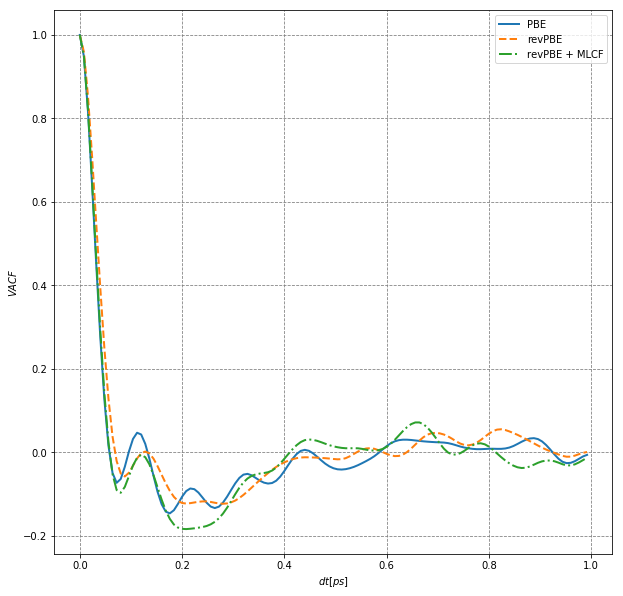

In [131]:
figsize(10,10)
skip = []
# skip = ['mbpol']
# skip = []
# labels = ['n = 1' , 'n = 5', 'n = 8', 'n = 10', 'n = $\infty$', 'MB-pol']
labels = ['PBE', 'revPBE', 'revPBE + MLCF', 'PBE + MLCF(H exact)']
styles = ['-','--','-.',':',':', '-']
for key, name, style in zip(v_corr_dict,labels, styles):
    if key in skip: continue
    sum_ = np.sum(v_corr_dict[key])/(fs**2)/1000
    plot(dt/1000, v_corr_dict[key], label = name, ls = style, lw = 2)
    print(sum_)
ylabel('$VACF$')
xlabel('$dt [ps]$')
# xticks(range(0,201,25),range(0,401,50))
legend()
grid(color = 'grey', ls = '--')
savefig('../../../Dropbox/SebastianSBU/presentations/2018_11_report/v_autocorr_revpbe.eps', bbox_inches = 'tight')
savefig('../../../Dropbox/SebastianSBU/presentations/2018_11_report/v_autocorr_revpbe.pdf', bbox_inches = 'tight')

In [11]:
from scipy.fftpack import fft, fftshift

In [21]:
v_corr_dict = {}
limits = ['8000:12000:1']* len(paths)
for path, lim in zip(paths, limits):
    name = path.split('/')[-2]
    dt = np.arange(0,800,1).astype(int) # Dont change these values as otherwise the labels will be incorrect!
    v_corr_dict[name] = view.map_sync(get_t_corr_vib, dt, [path]*len(dt), [lim]*len(dt))

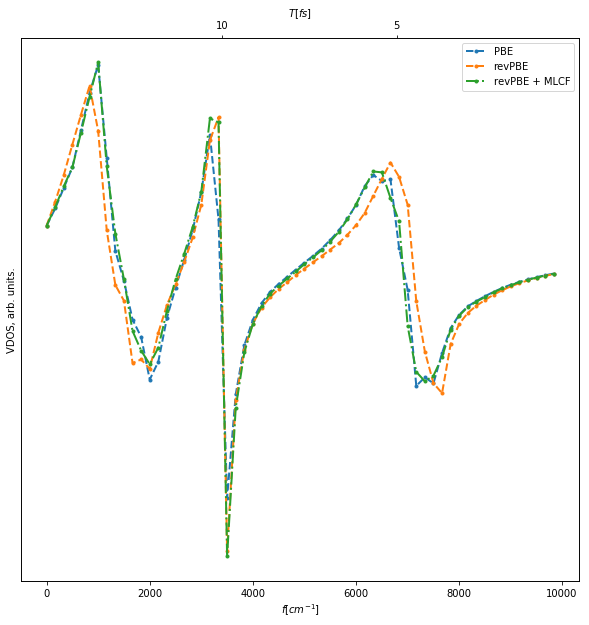

In [30]:
figsize(10,10)
skip = []
labels = ['PBE', 'revPBE', 'revPBE + MLCF', 'PBE + MLCF(H exact)']
skip = ['md_siesta_uftombp_15', 'md_siesta_uftombp_5',  'md_siesta_uftodztombp_P_5']
styles = ['--','--','-.',':',':', '-']
fig, ax = subplots()
for key, name, style in zip(v_corr_dict,labels, styles):
    if key in skip: continue
    ax.plot(np.arange(0,60)*5*33.36,fft(v_corr_dict[key])[0:60].imag, label = name, ls = style, lw=2, marker = '.')
    
ax2 = twiny()

ax2.set_xticks(np.array([1767.82048,3335.6409])/5000 + 0.006)
ax2.set_xticklabels([10,5])
ax.set_ylabel('VDOS, arb. units.')
ax.set_yticks([])
ax.set_xlabel('$f [cm^{-1}]$')
ax2.set_xlabel('$T[fs]$')
ax2.xaxis.set_ticks_position('top') # the rest is the same
# ylim(-0.5,12.9)

ax.legend()
# grid(color = 'grey', ls = '--')

# savefig('../../../Dropbox/SebastianSBU/presentations/2018_11_report/vdos_revpbe.eps', bbox_inches = 'tight')
# savefig('../../../Dropbox/SebastianSBU/presentations/2018_11_report/vdos_revpbe.pdf', bbox_inches = 'tight')

In [27]:
fft(v_corr_dict[key])[0:30]

array([ 0.51729898 +0.j        ,  1.31793377 +1.1171965j ,
        1.13007697 +2.37255599j,  1.60870972 +3.50044992j,
        2.73802953 +5.58871438j,  4.40754487 +7.72573887j,
       10.05984903 +9.8149546j , 13.91337079 +3.56128402j,
       13.87320335 -0.46660483j, 15.36061854 -3.21983301j,
       11.38750235 -6.31666665j, 10.3153461  -7.49437808j,
        7.66837313 -8.31467924j,  3.04356819 -7.3084367j ,
        1.8297463  -5.10028399j,  1.58155495 -3.22284716j,
        1.63094851 -1.69271945j,  2.01172459 -0.06292554j,
        2.61502659 +2.05533823j,  5.85949595 +6.44916622j,
       26.83815671 +6.20331221j,  7.98996395-19.85498672j,
        1.36394393-10.93641685j,  0.68603808 -7.60759787j,
        0.59492639 -5.87485155j,  0.65721521 -4.81990397j,
        0.72201828 -4.06962496j,  0.78170339 -3.59602342j,
        0.74973849 -3.16539509j,  0.7259579  -2.74318144j])